# Multireference

In [12]:
import numpy as np
import re
from itertools import islice
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as const

import os
import sys
from pathlib import Path
from matplotlib import style
from lmfit import Parameters, fit_report, minimize
from lmfit.models import LinearModel
style.use('default')                # needed for vscode dark theme to see the axis

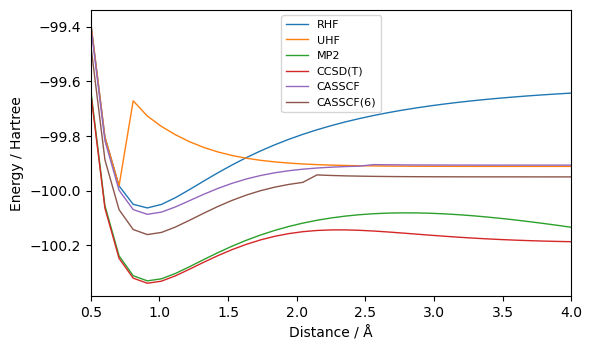

NameError: name 'save_plot_as_pdf' is not defined

In [13]:
# Load data
RHF = np.loadtxt('rhf/rhf.trjact.dat', usecols=(1), skiprows=1)
UHF = np.loadtxt('uhf/uhf.trjact.dat', usecols=(1), skiprows=1)
CCSD_T = np.loadtxt('CCSD(T)/CCSD_T.trjact.dat', usecols=(1), skiprows=1)
CASSCF = np.loadtxt('CASSCF/CASSCF_2.trjact.dat', usecols=(1), skiprows=1)
CASSCF_6 = np.loadtxt('CASSCF/CASSCF_6.trjact.dat', usecols=(1), skiprows=1)
MP2 = np.loadtxt('MP2/MP2.trjact.dat', usecols=(1), skiprows=1)
x = np.loadtxt('rhf/rhf.trjact.dat', usecols=(0), skiprows=1)

# define figure
fig_width = 6.202
fig_height = fig_width * 0.6
fig = plt.figure(figsize=(fig_width, fig_height))
spec = fig.add_gridspec(ncols=1, nrows=1, height_ratios=[1])

# define subplots
ax1 = fig.add_subplot(spec[0, 0])

# plot data
lw = 1.0 
ax1.plot(x, RHF, label='RHF', linewidth=lw)
ax1.plot(x, UHF, label='UHF', linewidth=lw)
ax1.plot(x, MP2, label='MP2', linewidth=lw)
ax1.plot(x, CCSD_T, label='CCSD(T)', linewidth=lw)
ax1.plot(x, CASSCF, label='CASSCF', linewidth=lw)
ax1.plot(x, CASSCF_6, label='CASSCF(6)', linewidth=lw)

# set labels
ax1.set_xlabel('Distance / Å')
ax1.set_ylabel('Energy / Hartree')

# set limits
ax1.set_xlim(0.5, 4.0)

# set legend and title
ax1.legend(loc='best', fancybox=True, fontsize=8)

# show plot
plt.show()

# save plot
save_plot_as_pdf(fig, 'Plots/MR_methods.pdf')